In [1]:
import subprocess
#import nglview as nv
from ase.calculators.castep import Castep
from ase.atoms import Atoms
from ase.io import read, write
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep
from ase.io.castep import read_castep_cell
import pandas as pd
from mp_api.client import MPRester

from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.core.surface import SlabGenerator, generate_all_slabs, Slab, miller_index_from_sites, get_d
from pymatgen.core.interface import Interface
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.wulff import WulffShape
from pymatgen.analysis.structure_matcher import *
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.symmetry.kpath import KPathLatimerMunro
from pymatgen.vis.structure_chemview import quick_view
#from wulffpack import SingleCrystal

from python_functions import *
from calculation_class import *
#from ../../script_share/bs_plotter_felix_mod import *

c:\Users\fcm19\Miniconda3\envs\matchem\lib\site-packages\paramiko\pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\fcm19\Miniconda3\envs\matchem\lib\site-packages\paramiko\transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
c:\Users\fcm19\Miniconda3\envs\matchem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# View xyz files

In [10]:
view(read('../../../MRes/MRes_Project/Calculations/Files/Interface/Interface_prerelaxed_Ag_adsorbed/Ag_origin_moiety/05_24_relax/Interface_close_s12_relax.xyz',index = ':'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [8]:
view(read('./structures/Interface/NEB_01_24/close_step_opt/s1_positions.xyz',index=':'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [15]:
view(read('./structures/Interface/NEB_01_24/s1_positions.xyz',index=':'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

# Make energy graphs for optimisation

In [10]:
def create_charges(cell_xyz,positions,symbols,bader_file,displacement=1e-4):
    charges = np.zeros(len(positions))
    Bohr = 0.52917721
    pseudo_charges = {
        'H' : 1,
        'O' : 6,
        'Zn': 12,
        'Ag': 11,
    }
    with open(bader_file) as fd:
        lines = fd.readlines()
    sep = '---------------'
    i = 0  # Counter for the lines
    k = 0  # Counter of sep
    assume6columns = False
    for line in lines:
        if line[0] == '\n':  # check if there is an empty line in the
            i -= 1           # head of ACF.dat file
        if i == 0:
            headings = line
            if 'BADER' in headings.split():
                j = headings.split().index('BADER')
            elif 'CHARGE' in headings.split():
                j = headings.split().index('CHARGE')
            else:
                print('Can\'t find keyword "BADER" or "CHARGE".'
                      ' Assuming the ACF.dat file has 6 columns.')
                j = 4
                assume6columns = True
        if sep in line:  # Stop at last separator line
            if k == 1:
                break
            k += 1
        if not i > 1:
            pass
        else:
            words = line.split()
            if assume6columns is True:
                if len(words) != 6:
                    raise IOError('Number of columns in ACF file incorrect!\n'
                                  'Check that Bader program version >= 0.25')
            safe = np.zeros(3)
            atom = positions[i-2]
            for u in range(3):
                safe[u] = atom[u]
                atom[u] = atom[u]%cell_xyz[u]
            charges[i-2] = pseudo_charges[symbols[i-2]] - float(words[j])
            if displacement is not None:  # check if the atom positions match
                xyz = np.array([float(w) for w in words[1:4]])
                # ACF.dat units could be Bohr or Angstrom
                norm1 = np.linalg.norm(atom - xyz)
                norm2 = np.linalg.norm(atom - xyz * Bohr)
                # print(symbols[i-2] ,positions[i-2], xyz,xyz * Bohr, norm1, norm2)
                # assert norm1 < displacement or norm2 < displacement
            positions[i-2] = safe
        i += 1
    return charges;

In [11]:
from ase.io.bader import attach_charges
interface = read('./structures/Interface/NEB_01_24/hydrated_split/Interface_hydrated_opt.positions.xyz')
cell = [0,0,0]
for i in range(3):
    cell[i] = np.linalg.norm(interface.cell[:,i])
charges = create_charges(cell, interface.positions,interface.symbols,'./structures/Interface/NEB_01_24/hydrated_split/ACF.dat')
interface.set_initial_charges(charges)
view(interface)

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [19]:
generate_video('./povray_folder','optimisation_orig.mp4',30)

['Ag196O240Zn240.000.png', 'Ag196O240Zn240.001.png', 'Ag196O240Zn240.002.png', 'Ag196O240Zn240.003.png', 'Ag196O240Zn240.004.png', 'Ag196O240Zn240.005.png', 'Ag196O240Zn240.006.png', 'Ag196O240Zn240.007.png', 'Ag196O240Zn240.008.png', 'Ag196O240Zn240.009.png', 'Ag196O240Zn240.010.png', 'Ag196O240Zn240.011.png', 'Ag196O240Zn240.012.png', 'Ag196O240Zn240.013.png', 'Ag196O240Zn240.014.png', 'Ag196O240Zn240.015.png', 'Ag196O240Zn240.016.png', 'Ag196O240Zn240.017.png', 'Ag196O240Zn240.018.png', 'Ag196O240Zn240.019.png', 'Ag196O240Zn240.020.png', 'Ag196O240Zn240.021.png', 'Ag196O240Zn240.022.png', 'Ag196O240Zn240.023.png', 'Ag196O240Zn240.024.png', 'Ag196O240Zn240.025.png', 'Ag196O240Zn240.026.png', 'Ag196O240Zn240.027.png', 'Ag196O240Zn240.028.png', 'Ag196O240Zn240.029.png', 'Ag196O240Zn240.030.png', 'Ag196O240Zn240.031.png', 'Ag196O240Zn240.032.png', 'Ag196O240Zn240.033.png', 'Ag196O240Zn240.034.png', 'Ag196O240Zn240.035.png', 'Ag196O240Zn240.036.png', 'Ag196O240Zn240.037.png', 'Ag196O240Z

In [45]:
electrode = 0
electrolyte = 0
for atom in interface:
    if atom.position[2] < 11:
        electrode += atom.charge
    else:
        electrolyte += atom.charge
print(electrode,electrolyte)
print(electrolyte+electrode)

-1.4254560000000023 1.4314520000000046
0.005996000000002333


In [17]:
from constants import Har2eV
def extract_difference_data(file:str,reference:float=0):
    aligned_data = []
    data = np.genfromtxt(file,delimiter=',')
    for i in range(len(data)):
        aligned_data.append([i,(data[i]-reference)*Har2eV])
    return np.array(aligned_data)
step1 = np.genfromtxt('./structures/Interface/NEB_01_24/interface_orig_opt/s1_energy.dat')
step1f = np.genfromtxt('./structures/Interface/NEB_01_24/interface_orig_opt/s1_Graderror.dat')
view(read('./structures/Interface/NEB_01_24/interface_orig_opt/s1_positions.xyz',index=':'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

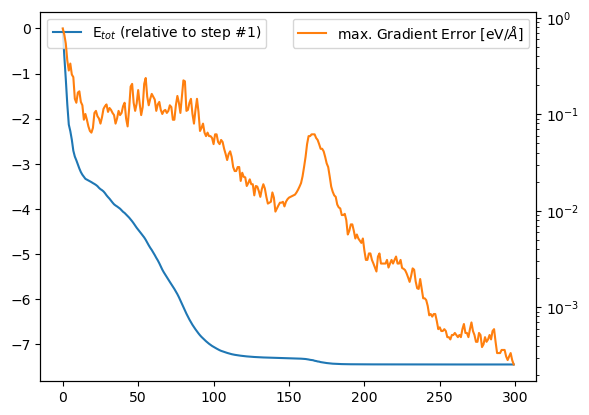

In [10]:
fig,ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(step1[:,0],step1[:,1]-step1[0,1],label='E$_{tot}$ (relative to step #1)')
ax2.plot(step1[:,0],step1f*25.710,c='tab:orange',label = 'max. Gradient Error [eV/$\AA$]')
# ax.plot(step8[:,0],step8[:,1],label='Final Step NEB')
# ax.plot(step12[:,0],step12[:,1],label='Next position over')
# ax.set_ylabel('$E-E_0$(Final Step NEB)')
ax2.legend(loc = 'upper right')
ax2.set_yscale('log')
ax.legend(loc='upper left')
plt.savefig('./structures/Interface/NEB_01_24/energies_forces_s1.png',dpi = 250)

In [12]:
from constants import Har2eV
def extract_difference_data(file:str,reference:float=0):
    aligned_data = []
    data = np.genfromtxt(file,delimiter=',')
    for i in range(len(data)):
        aligned_data.append([i,(data[i]-reference)*Har2eV])
    return np.array(aligned_data)
reference = np.genfromtxt('./structures/Interface/NEB_01_24/interface_orig_opt/cutoff_47Ry/Interface_bare_neb_energy.dat',delimiter=',')[0]
step1 = extract_difference_data('./structures/Interface/NEB_01_24/interface_orig_opt/cutoff_47Ry/Interface_bare_neb_energy.dat',0)
step1f = np.genfromtxt('./structures/Interface/NEB_01_24/interface_orig_opt/cutoff_47Ry/Interface_bare_neb_Graderror.dat')
view(read('./structures/Interface/NEB_01_24/interface_orig_opt/cutoff_47Ry/Interface_bare_neb_positions.xyz',index=':'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

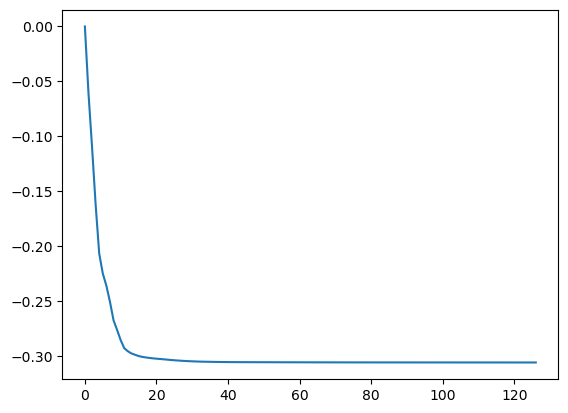

In [3]:
from constants import Har2eV
low_cutoff = np.genfromtxt('./structures/Interface/NEB_01_24/interface_orig_opt/s1_energy.dat',delimiter=',')*Har2eV
high_cutoff = np.genfromtxt('./structures/Interface/NEB_01_24/interface_orig_opt/cutoff_47Ry/Interface_bare_neb_energy.dat',delimiter=',')*Har2eV
# plt.plot(low_cutoff)
plt.plot(high_cutoff-high_cutoff[0])

In [5]:
from constants import Har2eV
def extract_difference_data(file:str,reference:float=0):
    aligned_data = []
    data = np.genfromtxt(file,delimiter=',')
    for i in range(len(data)):
        aligned_data.append([i,(data[i]-reference)*Har2eV])
    return np.array(aligned_data)
energy_middle = np.genfromtxt('./structures/Interface/NEB_01_24/middle_step_opt/Interface_bare_opt_middle_energy.dat',delimiter=',')*Har2eV
step1f = np.genfromtxt('./structures/Interface/NEB_01_24/middle_step_opt/Interface_bare_opt_middle_Graderror.dat')
view(read('./structures/Interface/NEB_01_24/middle_step_opt/Interface_bare_opt_middle_positions.xyz',index=':'))

NameError: name 'np' is not defined

In [5]:
from constants import Har2eV
def extract_difference_data(file:str,reference:float=0):
    aligned_data = []
    data = np.genfromtxt(file,delimiter=',')
    for i in range(len(data)):
        aligned_data.append([i,(data[i]-reference)*Har2eV])
    return np.array(aligned_data)
energy_far = np.genfromtxt('./structures/Interface/NEB_01_24/far_step_opt/Interface_bare_opt_far_energy.dat',delimiter=',')*Har2eV
# step1f = np.genfromtxt('./structures/Interface/NEB_01_24/far_step_opt/Interface_bare_opt_middle_Graderror.dat')
# view(read('./structures/Interface/NEB_01_24/far_step_opt/Interface_bare_opt_middle_positions.xyz',index=':'))

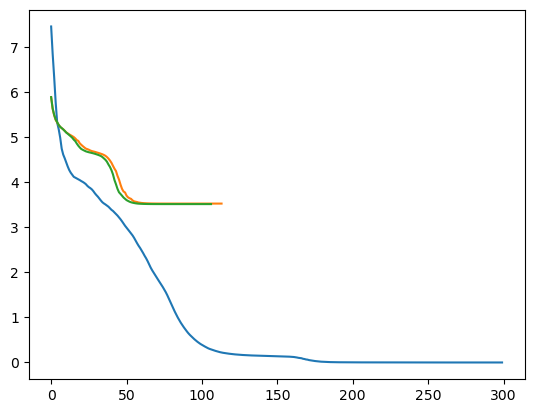

In [6]:
energy_orig = np.genfromtxt('./structures/Interface/NEB_01_24/interface_orig_opt/s1_energy.dat')*Har2eV
plt.plot(energy_orig-energy_orig[-1])
plt.plot(energy_middle-energy_orig[-1])
plt.plot(energy_far-energy_orig[-1])

In [23]:
print(energy_orig[0])
print(energy_orig[-1])


-1685431.2524368647
-1685438.7010384211


In [24]:
print(energy_middle[-1]-energy_orig[-1])
print(energy_far[-1]-energy_orig[-1])

3.5224636972416192
3.511074906680733


In [3]:
from constants import Har2eV
def extract_difference_data(file:str,reference:float=0):
    aligned_data = []
    data = np.genfromtxt(file,delimiter=',')
    for i in range(len(data)):
        aligned_data.append([i,(data[i]-reference)*Har2eV])
    return np.array(aligned_data)
reference = np.genfromtxt('./structures/Interface/NEB_01_24/hydrated_split/Interface_hydrated_opt_energy.dat',delimiter=',')
step1 = extract_difference_data('./structures/Interface/NEB_01_24/hydrated_split/Interface_hydrated_opt_energy.dat',0)
step1f = np.genfromtxt('./structures/Interface/NEB_01_24/hydrated_split/Interface_hydrated_opt_Graderror.dat')
view(read('./structures/Interface/NEB_01_24/hydrated_split/Interface_hydrated_opt_positions.xyz',index=':'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [ ]:
fig,ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(step1[:,0],step1[:,1]-step1[0,1],label='E$_{tot}$ (relative to step #1)')
ax2.plot(step1[:,0],step1f*25.710,c='tab:orange',label = 'max. Gradient Error [eV/$\AA$]')
# ax.plot(step8[:,0],step8[:,1],label='Final Step NEB')
# ax.plot(step12[:,0],step12[:,1],label='Next position over')
# ax.set_ylabel('$E-E_0$(Final Step NEB)')
ax2.legend(loc = 'upper right')
ax2.set_yscale('log')
ax.legend(loc='upper left')
plt.savefig('./structures/Interface/NEB_01_24/energies_forces_s1.png',dpi = 250)

# Create force multipliers for partial optimisations

In [7]:
start = read('./structures/Interface/NEB_01_24/interface_orig_opt/Interface_fully_optimised.xyz')
charges = np.zeros(len(start.get_initial_charges()))
for i in range(len(start.get_initial_charges())):
    if start.get_distance(59,i) < 6.5:
        charges[i] = 1.0
start = read('./structures/Interface/NEB_01_24/Interface_close_half.xyz')
for i in range(len(start.get_initial_charges())):
    if start.get_distance(59,i) < 6.5:
        charges[i] = 1.0
start = read('./structures/Interface/NEB_01_24/Interface_close.xyz')
for i in range(len(start.get_initial_charges())):
    if start.get_distance(59,i) < 6.5:
        charges[i] = 1.0
start = read('./structures/Interface/NEB_01_24/interface_middle.xyz')
for i in range(len(start.get_initial_charges())):
    if start.get_distance(59,i) < 6.5:
        charges[i] = 1.0
start = read('./structures/Interface/NEB_01_24/interface_far.xyz')
for i in range(len(start.get_initial_charges())):
    if start.get_distance(59,i) < 6.5:
        charges[i] = 1.0

forces = ''
for charge in charges:
    if charge: 
        forces += '1 1 1\n'
    else:
        forces += '0 0 0\n'
print(forces)
# charges[59] = 1.0
start.set_initial_charges(charges)
view(start)

0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
1 1 1
1 1 1
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
1 1 1
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
1 1 1
0 0 0
1 1 1
1 1 1
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
0 0 0
0 0 0
0 0 0
1 1 1
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
1 1 1
0 0 0
0 0 0
1 1 1
1 1 1
0 0 

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

# Hydrated surfaces

In [15]:
split_test = read('./structures/Interface/hydrated_surface/geom_split_test.xyz')
split_test_pos = split_test.get_positions()
split = read('./structures/Interface/hydrated_surface/geom_split.xyz')
split_pos = split.get_positions()
charges = []
for i in range(len(split.get_initial_charges())):
    temp = abs(split_pos[i]-split_test_pos[i])
    dist = np.sqrt(temp[0]**2+temp[1]**2+temp[2]**2)
    charges.append(dist)
print(charges)
split.set_initial_charges(charges)
view(split)
print(np.sum(charges))

[0. 0. 0.]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [16]:
view(read('./structures/Interface/NEB_01_24/Interface_fully_optimised.xyz'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>

In [17]:
view(read('./structures/Interface/hydrated_surface/geom_split.xyz'))

<Popen: returncode: None args: ['c:\\Users\\fcm19\\Miniconda3\\envs\\matchem...>